run this on google collab

In [1]:
# general imports
import yfinance as yf
import pandas as pd

In [2]:
# imports for model
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

## Data


### Loading in Data

In [3]:
# YFINANCE
# create a ticker object, then get history
btc_tk = yf.Ticker("BTC-USD")
btc_all_data_raw = btc_tk.history(period="max")

btc_f_tk = yf.Ticker("BTC=F")
btc_futures_all_data = btc_f_tk.history(period="max")

vix_tk = yf.Ticker("^VIX")
vix_all_data = vix_tk.history(period="max")

btc_hourly = pd.read_csv("kaggle_btc_hourly.csv")

In [4]:
# Kaggle data
btc_hourly = pd.read_csv("kaggle_btc_hourly.csv")
# btc_tweets_smallest = pd.read_pickle('btc_tweets_smallest.pkl')
# btc_tweets_smallest.head()

In [5]:
# 2020-01-02 to 2022-03-01
btc_hourly.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06
1,1646089200,2022-02-28 23:00:00,BTC/USD,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06
2,1646085600,2022-02-28 22:00:00,BTC/USD,41657.23,44256.08,41650.29,42907.32,527.540571,2.263535e+07
3,1646082000,2022-02-28 21:00:00,BTC/USD,41917.09,41917.09,41542.60,41659.53,69.751680,2.905822e+06
4,1646078400,2022-02-28 20:00:00,BTC/USD,41361.99,41971.00,41284.11,41914.97,247.151654,1.035935e+07


In [ ]:
# # one time code
# btc_tweets_large = pd.read_csv("Bitcoin_tweets.csv", engine='python')
# btc_tweets_small = btc_tweets_large[["user_followers", "user_verified", "date", "text", "hashtags", "source", "is_retweet"]]
# btc_tweets_small.to_pickle('btc_tweets_small.pkl')

# btc_tweets_smallest = pd.read_csv("Bitcoin_tweets_dataset_2.csv", engine='python')
# btc_tweets_smallest = btc_tweets_smallest[["user_followers", "user_verified", "date", "text", "hashtags", "source", "is_retweet"]]
# btc_tweets_smallest.to_pickle('btc_tweets_smallest.pkl')

# btc_tweets_smallest.to_pickle('~/btc_tweets_smallest.pkl')

,user_followers,user_verified,date,text,hashtags,source,is_retweet
0,4680.0,False,2023-03-01 23:59:59,Which #bitcoin books should I think about read...,['bitcoin'],Twitter for iPhone,False
1,770.0,False,2023-03-01 23:59:47,"@ThankGodForBTC I appreciate the message, but ...",['Bitcoin'],Twitter for iPhone,False
2,576.0,False,2023-03-01 23:59:42,#Ethereum price update: \n\n#ETH $1664.02 USD\...,"['Ethereum', 'ETH', 'Bitcoin', 'BTC', 'altcoin...",Twitter Web App,False
3,236.0,False,2023-03-01 23:59:36,CoinDashboard v3.0 is here\nAvailable on ios a...,['Bitcoin'],Twitter for Android,False
4,12731.0,False,2023-03-01 23:59:32,#Bitcoin Short Term Fractal (4H)💥\n\nIn lower ...,"['Bitcoin', 'BTC']",Twitter Web App,False


In [6]:
# Fear and greed data
mkt_sentiment = pd.read_csv("btc_fearandgreed.csv")
mkt_sentiment.set_index('Date', inplace=True)

In [7]:
mkt_sentiment.tail()

,Value,Value_Classification,BTC_Closing,BTC_Volume
Date,,,,
2023-03-27,64.0,Greed,27139.888672,18188895178
2023-03-28,59.0,Greed,27268.130859,17783600385
2023-03-29,57.0,Greed,28348.441406,20684945906
2023-03-30,60.0,Greed,28033.562500,22435349951
2023-03-31,63.0,Greed,28478.484375,19001327598


### Cleaning Data

In [8]:
def clean_data(data, start="2020-01-01", end="2023-03-31"):

    # # set Date to index if not already
    # data.set_index('Date', inplace=True)

    # filter with and start and end
    if start:
        data = data[data.index >= start]
    if end:
        data = data[data.index <= end]

    # check number of NA rows
    print(f"{data.isna().any(axis=1).sum()} / {len(data)} has NA in the row" )

    return data

In [9]:
btc_all_data = clean_data(btc_all_data_raw)
vix_all_data =  clean_data(vix_all_data)
mkt_sentiment =  clean_data(mkt_sentiment)

0 / 1186 has NA in the row
0 / 818 has NA in the row
0 / 1186 has NA in the row


In [10]:
mkt_sentiment.tail()

,Value,Value_Classification,BTC_Closing,BTC_Volume
Date,,,,
2023-03-27,64.0,Greed,27139.888672,18188895178
2023-03-28,59.0,Greed,27268.130859,17783600385
2023-03-29,57.0,Greed,28348.441406,20684945906
2023-03-30,60.0,Greed,28033.562500,22435349951
2023-03-31,63.0,Greed,28478.484375,19001327598


In [11]:
mkt_sentiment.head()

,Value,Value_Classification,BTC_Closing,BTC_Volume
Date,,,,
2020-01-01,37.0,Fear,7200.174316,18565664997
2020-01-02,39.0,Fear,6985.470215,20802083465
2020-01-03,38.0,Fear,7344.884277,28111481032
2020-01-04,38.0,Fear,7410.656738,18444271275
2020-01-05,39.0,Fear,7411.317383,19725074095


### CNN-LSTM Model



* still use entire dataset for training - scattering training and testing across time might mess with the model picking up patterns
* have dataset split by day for making trade decision / computing returns

#### Setting up data for model inputs
* tried a multi input CNN LSTM with a sentiment dataset (fear and greed), made the model worse



In [12]:
btc_hourly = btc_hourly.sort_values(by=['unix'], ascending=True)
btc_hourly.head()
btc_hourly["day"] = pd.to_datetime(btc_hourly['date']).dt.date
btc_hourly = btc_hourly[btc_hourly['day'] > pd.to_datetime('2020-01-01').date()] # restrict to after 2020
btc_hourly.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD,day
18936,1577923200,2020-01-02 00:00:00,BTC/USD,7178.68,7184.94,7163.01,7184.86,119595.30,16.67,2020-01-02
18935,1577926800,2020-01-02 01:00:00,BTC/USD,7184.86,7184.86,7158.10,7163.27,280024.20,39.07,2020-01-02
18934,1577930400,2020-01-02 02:00:00,BTC/USD,7163.27,7166.01,7125.00,7142.87,1007304.71,141.08,2020-01-02
18933,1577934000,2020-01-02 03:00:00,BTC/USD,7142.87,7142.87,7092.70,7103.23,1951984.84,274.40,2020-01-02
18932,1577937600,2020-01-02 04:00:00,BTC/USD,7103.23,7133.34,7080.00,7113.65,866797.82,121.96,2020-01-02


In [13]:
import math
from sklearn.preprocessing import MinMaxScaler

# https://www.geeksforgeeks.org/time-series-forecasting-using-pytorch/

all_data = btc_hourly[["unix", "open", "high", "low", "close", "Volume BTC", "date"]]
# all_data = btc_all_data[["Open", "High", "Low", "Close", "Volume"]] # daily data - date is the index
all_data.columns = all_data.columns.str.lower()

# same some for validation
# 30 days?
reserve_idxs = 30 * 24
all_data = all_data.iloc[:-reserve_idxs]

training_col = "close"

# split into training and testing data (no validaon set)
training_data_len = math.ceil(len(all_data) * .8)
train_data = all_data[:training_data_len].iloc[:, :]
test_data = all_data[training_data_len:].iloc[:, :]

print(f"train data range: {train_data['date'].iloc[0]} {train_data['date'].iloc[-1]}")
print(f"test data range: {test_data['date'].iloc[0]} {test_data['date'].iloc[-1]}")

# set up training dataset
dataset_train = train_data[training_col].values
dataset_train = np.reshape(dataset_train, (-1, 1))
print(dataset_train.shape)

# set up testing dataset
dataset_test = test_data[training_col].values
dataset_test = np.reshape(dataset_test, (-1, 1))
print(dataset_test.shape)

# normalizing values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(dataset_train)
# print(scaled_train[:5])
scaled_test = scaler.fit_transform(dataset_test)
# print(scaled_test[:5])

sequence_length = 50  # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i + sequence_length])
    y_train.append(scaled_train[i + sequence_length])  # Predicting the value right after the sequence
X_train, y_train = np.array(X_train), np.array(y_train)

# convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

# create sequences and labels for testing data
sequence_length = 30  # number of time steps to look back. ... do these need to be the same length
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i + sequence_length])
    y_test.append(scaled_test[i + sequence_length])
X_test, y_test = np.array(X_test), np.array(y_test)

# convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)

train data range: 2020-01-02 00:00:00 2021-08-31 05:00:00
test data range: 2021-08-31 06:00:00 2022-01-30 00:00:00
(14574, 1)
(3643, 1)
torch.Size([14524, 50, 1]) torch.Size([14524, 1])
torch.Size([3613, 30, 1]) torch.Size([3613, 1])


In [14]:
train_data.head()

,unix,open,high,low,close,volume btc,date
18936,1577923200,7178.68,7184.94,7163.01,7184.86,119595.30,2020-01-02 00:00:00
18935,1577926800,7184.86,7184.86,7158.10,7163.27,280024.20,2020-01-02 01:00:00
18934,1577930400,7163.27,7166.01,7125.00,7142.87,1007304.71,2020-01-02 02:00:00
18933,1577934000,7142.87,7142.87,7092.70,7103.23,1951984.84,2020-01-02 03:00:00
18932,1577937600,7103.23,7133.34,7080.00,7113.65,866797.82,2020-01-02 04:00:00


In [30]:
# # Fear & Greed Data Preparation
# fear_greed_df = mkt_sentiment[['Value']]  # Assuming 'value' is the column name

# # Split into training and testing data
# training_data_len_fg = math.ceil(len(fear_greed_df) * 0.8)
# train_data_fg = fear_greed_df[:training_data_len_fg]
# test_data_fg = fear_greed_df[training_data_len_fg:]

# # convert training and testing data to numpy arrays and reshape
# dataset_train_fg = train_data_fg['Value'].values
# dataset_train_fg = np.reshape(dataset_train_fg, (-1, 1))
# dataset_test_fg = test_data_fg['Value'].values
# dataset_test_fg = np.reshape(dataset_test_fg, (-1, 1))

# # normalize
# scaler_fg = MinMaxScaler(feature_range=(0, 1))
# scaled_train_fg = scaler_fg.fit_transform(dataset_train_fg)
# scaled_test_fg = scaler_fg.transform(dataset_test_fg)

# # create sequences for training and testing data
# sequence_length = 50  # Same length as used for the price data
# X_train_fg, y_train_fg = [], []
# for i in range(len(scaled_train_fg) - sequence_length):
#     X_train_fg.append(scaled_train_fg[i:i + sequence_length])
#     y_train_fg.append(scaled_train_fg[i + sequence_length])  # Predicting the value after the sequence
# X_train_fg, y_train_fg = np.array(X_train_fg), np.array(y_train_fg)

# X_test_fg, y_test_fg = [], []
# for i in range(len(scaled_test_fg) - sequence_length):
#     X_test_fg.append(scaled_test_fg[i:i + sequence_length])
#     y_test_fg.append(scaled_test_fg[i + sequence_length])
# X_test_fg, y_test_fg = np.array(X_test_fg), np.array(y_test_fg)

# # Convert data to PyTorch tensors
# X_train_fg = torch.tensor(X_train_fg, dtype=torch.float32)
# y_train_fg = torch.tensor(y_train_fg, dtype=torch.float32)
# X_test_fg = torch.tensor(X_test_fg, dtype=torch.float32)
# y_test_fg = torch.tensor(y_test_fg, dtype=torch.float32)

# # Print shapes to verify
# print("Fear & Greed X_train_fg:", X_train_fg.shape, "y_train_fg:", y_train_fg.shape)
# print("Fear & Greed X_test_fg:", X_test_fg.shape, "y_test_fg:", y_test_fg.shape)

### Architecture

Follow a CNN-LSTM approach

Model Architecture
  1. CNN
  2. Max pooling
  3. LSTM
  4. Dropout
  5. LSTM
  6. Dropout
  7. Dense
  8. Dense

In [15]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

import numpy as np
from tqdm.notebook import tqdm

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict

In [16]:
import torch
import torch.nn as nn

class BTCPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, n_layers, dropout_rate=0.2):
        super(BTCPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers

        # Adjust CNN to handle `n_features` input channels (e.g., 5 for OHLCV data)
        self.c1 = nn.Conv1d(in_channels=n_features, out_channels=n_features, kernel_size=2, stride=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2)

        # LSTM layers with `input_size=n_features`
        self.lstm1 = nn.LSTM(
            input_size=n_features,  # Match number of features in each time step
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.dropout1 = nn.Dropout(dropout_rate)
        self.lstm2 = nn.LSTM(
            input_size=n_hidden,  # Output from LSTM 1 feeds to LSTM 2
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.dropout2 = nn.Dropout(dropout_rate)

        # Final linear layers
        self.linear1 = nn.Linear(in_features=n_hidden, out_features=1)
        self.linear2 = nn.Linear(in_features=n_hidden, out_features=1)

    def forward(self, sequences):
        # Expecting `sequences` to be (batch_size, seq_len, n_features)
        batch_size, seq_len, n_features = sequences.size()

        # Permute to match Conv1D expected input: (batch_size, n_features, seq_len)
        x = sequences.permute(0, 2, 1)
        x = self.c1(x)  # Apply Conv1D; shape becomes (batch_size, n_features, new_seq_len)
        x = self.maxpool(x)  # Apply MaxPool; shape becomes (batch_size, n_features, pooled_seq_len)

        # Permute to match LSTM expected input: (pooled_seq_len, batch_size, n_features)
        x = x.permute(2, 0, 1)

        # Initialize hidden state with dynamic batch size
        device = x.device
        hidden = (
            torch.zeros(self.n_layers, batch_size, self.n_hidden, device=device),
            torch.zeros(self.n_layers, batch_size, self.n_hidden, device=device)
        )

        # Pass through LSTM layers
        lstm_out1, _ = self.lstm1(x, hidden)
        lstm_out1 = self.dropout1(lstm_out1)
        lstm_out2, _ = self.lstm2(lstm_out1)
        lstm_out2 = self.dropout2(lstm_out2)

        # Use the last time step's output for prediction
        last_time_step = lstm_out2[-1, :, :]

        # Linear layers for final prediction
        y_pred1 = self.linear1(last_time_step)
        # y_pred2 = self.linear2(last_time_step)

        # # # Combine predictions
        # y_pred = y_pred1 + y_pred2

        y_pred = y_pred1

        return y_pred


In [223]:
# Model training - do on GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

input_size = 1
num_layers = 3
hidden_size = 128
output_size = 1
dropout = 0.2  #  dropout for regularization, 20%

model = BTCPredictor(input_size, hidden_size, num_layers, dropout).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Learning rate

batch_size = 24  # Adjusted batch size
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 50  # Increased number of epochs
train_hist = []
test_hist = []

for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

cuda
Epoch [10/50] - Training Loss: 0.0005, Test Loss: 0.0006
Epoch [20/50] - Training Loss: 0.0004, Test Loss: 0.0004
Epoch [30/50] - Training Loss: 0.0003, Test Loss: 0.0004
Epoch [40/50] - Training Loss: 0.0003, Test Loss: 0.0004
Epoch [50/50] - Training Loss: 0.0003, Test Loss: 0.0006


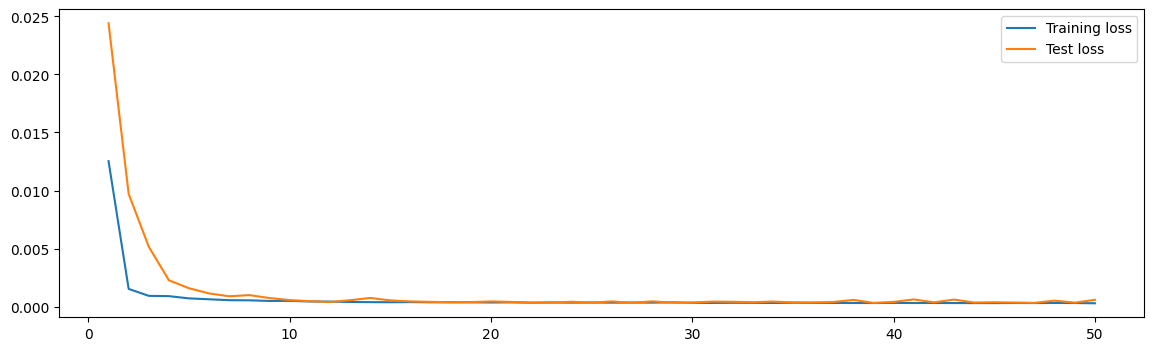

In [227]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

In [17]:
# import numpy as np
# import torch
# import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime

In [230]:
last_test_date = test_data.loc[test_data.index[0], 'date']
last_test_date

'2021-08-31 06:00:00'

In [20]:
# load in a model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = 1
num_layers = 3
hidden_size = 128
output_size = 1
dropout = 0.2  #  dropout for regularization, 20%

model = BTCPredictor(input_size, hidden_size, num_layers, dropout).to(device)
model.load_state_dict(torch.load("model_hourly_close3.pt",  map_location=torch.device('cpu')))
model.eval()

<ipython-input-20-ffd725cfeef5>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_hourly_close3.pt",  map_location=torch.device('cpu'

BTCPredictor(
  (c1): Conv1d(1, 1, kernel_size=(2,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm1): LSTM(1, 128, num_layers=3)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(128, 128, num_layers=3)
  (dropout2): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=128, out_features=1, bias=True)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
)

In [21]:
# prediction based off of test dataset (?)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prediction period in hours (adjusted from days for hourly data)
prediction_period_days = 1  # Number of days
num_forecast_steps = prediction_period_days * 24  # Convert to hours

# prepare historical data for prediction
sequence_to_plot = X_test.squeeze().cpu().numpy()  # Uses testing dataset?
historical_data = sequence_to_plot[-1]

forecasted_values = []
with torch.no_grad():
    for _ in range(num_forecast_steps):
        # Prepare historical data as input to the model
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
        forecasted_values.append(predicted_value)

        # Shift historical data for the next prediction
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

forecasted_values_rescaled = scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()

last_date = pd.to_datetime(test_data.loc[test_data.index[0], 'date']) # 0 for the latest date
future_dates = pd.date_range(start=last_date + pd.DateOffset(hours=1), periods=num_forecast_steps, freq='h')
# print(future_dates)

# Create DataFrame for forecasted values with corresponding dates
predicted_df = pd.DataFrame({
    'Date': future_dates,
    'Value': forecasted_values_rescaled,
})

# Evaluate the model and calculate RMSE and R² score
model.eval()
with torch.no_grad():
    test_predictions = []
    for batch_X_test in X_test:
        batch_X_test = batch_X_test.to(device).unsqueeze(0)  # Add batch dimension
        test_predictions.append(model(batch_X_test).cpu().numpy().flatten()[0])

test_predictions = np.array(test_predictions)

# Calculate RMSE and R² score
rmse = np.sqrt(mean_squared_error(y_test.cpu().numpy(), test_predictions))
r2 = r2_score(y_test.cpu().numpy(), test_predictions)

print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')


RMSE: 0.0201
R² Score: 0.9922


<Axes: xlabel='Date'>

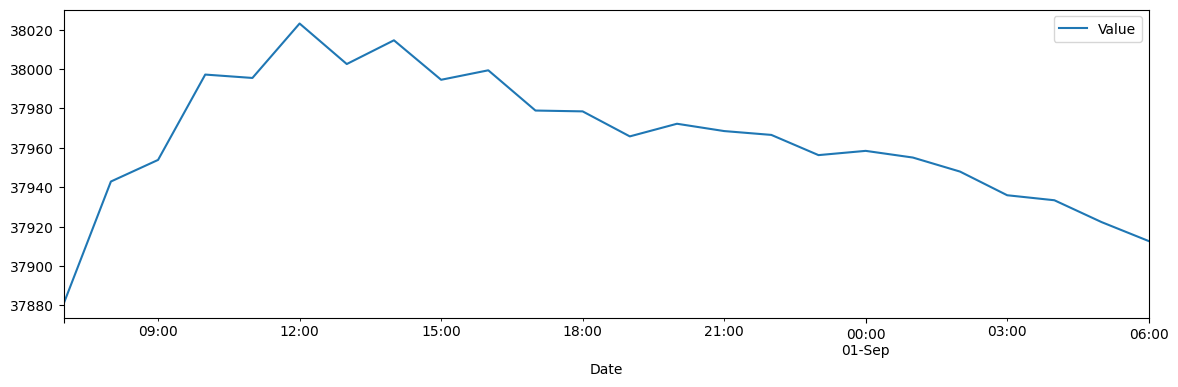

2021-08-31 07:00:00, 2021-09-01 06:00:00


<Axes: xlabel='date'>

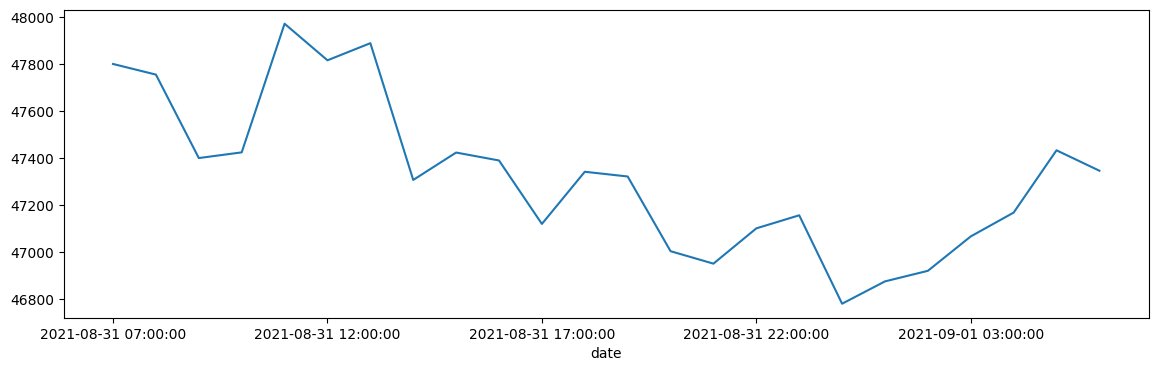

In [23]:
plt.rcParams['figure.figsize'] = [14, 4]

predicted_df.head()
first_date = predicted_df['Date'].min()
last_date = predicted_df['Date'].max()
print(f"{first_date}, {last_date}")

# from the original data
actual_data = btc_hourly[(btc_hourly['date'] >= str(first_date)) & (btc_hourly['date'] <= str(last_date))]
actual_data = actual_data.set_index("date")
actual_data['close'].plot()


In [24]:
reserved_data = all_data.iloc[-reserve_idxs:]
reserved_data.tail()

,unix,open,high,low,close,volume btc,date
724,1643486400,37882.20,38698.52,37847.08,38382.44,179.505538,2022-01-29 20:00:00
723,1643490000,38375.12,38741.67,38313.96,38390.65,58.315624,2022-01-29 21:00:00
722,1643493600,38418.50,38438.71,38054.69,38170.67,58.224885,2022-01-29 22:00:00
721,1643497200,38159.26,38217.07,37939.02,38192.65,71.051738,2022-01-29 23:00:00
720,1643500800,38176.45,38288.88,37765.79,37862.59,46.641903,2022-01-30 00:00:00


In [25]:
# try for a different date?

# prediction in unseen data
def data_to_tensor(data, predict_col="close", sequence_length = 30):
  # convert dataframe to tensors

  """
  sequence_length: num of steps to look back
  """

  dataset_predict = data[predict_col].values
  dataset_predict = np.reshape(dataset_predict, (-1, 1))

  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_predict = scaler.fit_transform(dataset_predict)

  X_predict, y_predict = [], []
  for i in range(len(scaled_predict) - sequence_length):
      X_predict.append(scaled_predict[i:i + sequence_length])
      y_predict.append(scaled_predict[i + sequence_length])  # Predicting the value right after the sequence
  X_predict, y_predict = np.array(X_predict), np.array(y_predict)

  # convert data to PyTorch tensors
  X_predict = torch.tensor(X_predict, dtype=torch.float32)
  y_predict = torch.tensor(y_predict, dtype=torch.float32)
  # print(X_predict.shape, y_predict.shape)

  return X_predict, y_predict


def predict_hourly(X_predict, data, predict_period_days=1):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # Prediction period in hours (adjusted from days for hourly data)
  # prediction_period_days = 1  # Number of days
  num_forecast_steps = prediction_period_days * 24  # Convert to hours

  # prepare historical data for prediction
  sequence_to_plot = X_predict.squeeze().cpu().numpy()  # Uses testing dataset?
  historical_data = sequence_to_plot[-1]

  # prepare historical data for prediction
  sequence_to_plot = X_predict.squeeze().cpu().numpy()  # Uses testing dataset?
  historical_data = sequence_to_plot[-1]

  forecasted_values = []
  with torch.no_grad():
      for _ in range(num_forecast_steps):
          # Prepare historical data as input to the model
          historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
          predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
          forecasted_values.append(predicted_value)

          # Shift historical data for the next prediction
          historical_data = np.roll(historical_data, shift=-1)
          historical_data[-1] = predicted_value

  forecasted_values_rescaled = scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()

  # confirmed last date is pulled correctly
  last_date = pd.to_datetime(data.loc[data.index[-1], 'date']) # 0 for the latest date
  print(f"predicting from this date: {last_date}")
  future_dates = pd.date_range(start=last_date + pd.DateOffset(hours=1), periods=num_forecast_steps, freq='h')

  # df for forecasted values with corresponding dates
  predicted_df = pd.DataFrame({
      'Date': future_dates,
      'Value': forecasted_values_rescaled,
  })
  return predicted_df


In [26]:
x_tensors, y_tensors = data_to_tensor(reserved_data)
test2 = predict_hourly(x_tensors, reserved_data)
test2

predicting from this date: 2022-01-30 00:00:00


,Date,Value
0,2022-01-30 01:00:00,44180.281250
1,2022-01-30 02:00:00,44492.601562
2,2022-01-30 03:00:00,43979.558594
3,2022-01-30 04:00:00,44062.765625
4,2022-01-30 05:00:00,43799.691406
5,2022-01-30 06:00:00,43813.457031
6,2022-01-30 07:00:00,43596.476562
7,2022-01-30 08:00:00,43658.679688
8,2022-01-30 09:00:00,43462.808594
9,2022-01-30 10:00:00,43457.152344


In [27]:
reserved_data.tail()

,unix,open,high,low,close,volume btc,date
724,1643486400,37882.20,38698.52,37847.08,38382.44,179.505538,2022-01-29 20:00:00
723,1643490000,38375.12,38741.67,38313.96,38390.65,58.315624,2022-01-29 21:00:00
722,1643493600,38418.50,38438.71,38054.69,38170.67,58.224885,2022-01-29 22:00:00
721,1643497200,38159.26,38217.07,37939.02,38192.65,71.051738,2022-01-29 23:00:00
720,1643500800,38176.45,38288.88,37765.79,37862.59,46.641903,2022-01-30 00:00:00


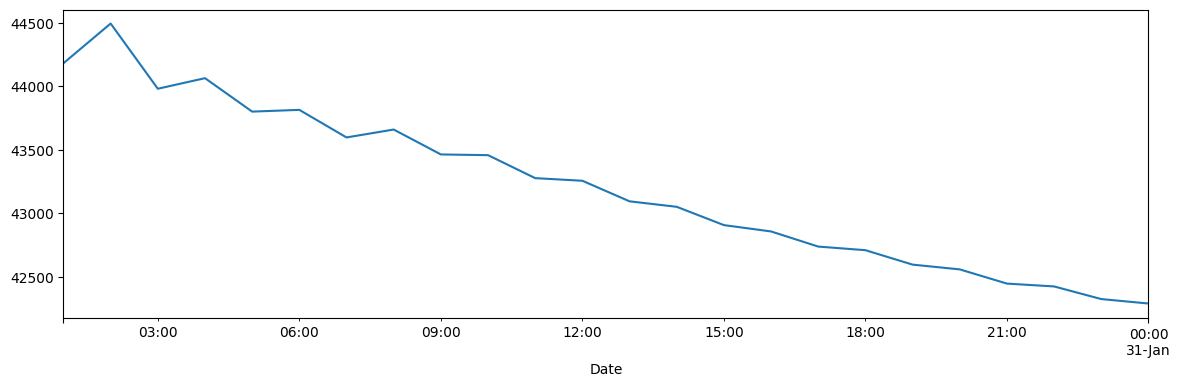

In [28]:
def plot_predicted(data):
  if "Date" in data.columns:
    data = data.set_index("Date")
  data['Value'].plot()

plot_predicted(test2)

2022-01-30 01:00:00, 2022-01-31 00:00:00


<Axes: xlabel='date'>

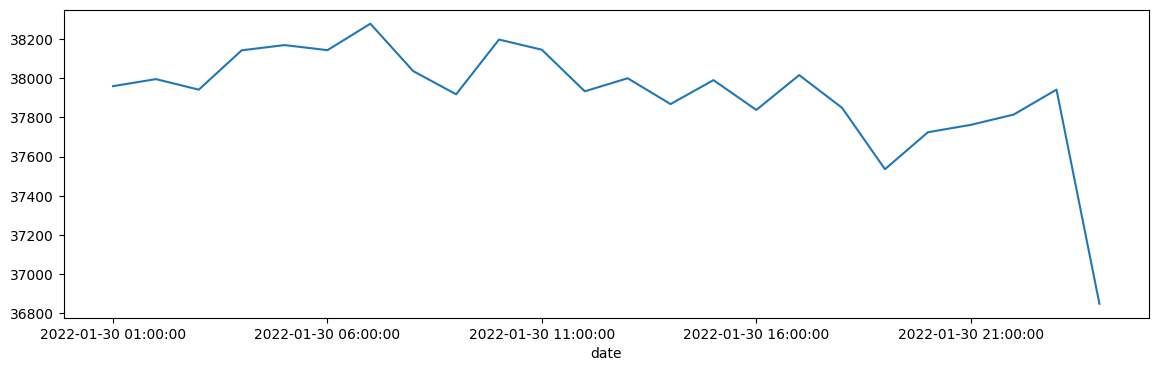

In [29]:
predicted = test2

first_date = predicted['Date'].min()
last_date = predicted['Date'].max()
print(f"{first_date}, {last_date}")

# from the original data
# for this date (2022-Jan-31) it is trending upwards if you look across a few days, but specially on 30-31 it went down
# .... maybe daily is too volatile? '2022-02-01'

actual_data = btc_hourly[(btc_hourly['date'] >= str(first_date)) & (btc_hourly['date'] <= str(last_date))]
actual_data = actual_data.set_index("date")
actual_data['close'].plot()


In [121]:
def daily_trade_return(predicted_data, window=3, fees=0.02):

  # get average of first few hours and last few hours
  begin = np.mean(predicted_data[0:3])
  end = np.mean(predicted_data[-3:])

  short_return = 0
  long_return = 0


  if begin > end:
    # short!
    sell_price = max(predicted_data[0:window])
    buy_price = min(predicted_data[-1*window:])
    short_return = (sell_price - buy_price) / buy_price

  else:
    buy_price = min(predicted_data[0:window])
    sell_price = max(predicted_data[-1*window:])

    long_return = (sell_price - buy_price) / buy_price

  print(f"trade: {buy_price} {sell_price}")

  return max(short_return, long_return, 0)


In [122]:
import itertools

returns = []
relevant_prices = []
all_predicted_prices = []

# Convert 'date' column to datetime and extract the day
reserved_data['day'] = pd.to_datetime(reserved_data['date']).dt.date
reserved_data_group = reserved_data.groupby(reserved_data["day"])

# Convert groupby object to a list of (name, group) tuples
groups = list(reserved_data_group)

# Ensure an even number of groups by truncating the last one if the count is odd
if len(groups) % 2 != 0:
    print(len(groups))
    groups = groups[:-3] # truncating a bit more so we have values at the end to validate

# Iterate through every 2 groups using itertools.zip_longest
group_iter = iter(groups)
for (name1, group1), (name2, group2) in itertools.zip_longest(group_iter, group_iter, fillvalue=None):
    if group2 is None:
        combined = group1  # If there's only one group, use it as is
    else:
        combined = pd.concat([group1, group2])  # Concatenate two groups if both are present

    # Convert to tensors & run prediction
    x_tensors, y_tensors = data_to_tensor(combined)
    predicted_prices = predict_hourly(x_tensors, combined)

    # Calculate return
    first_date = combined['date'].min()
    last_date = combined['date'].max()

    # get actual returns for the matching period
    relevant_period = reserved_data[(reserved_data['date'] >= first_date) & (reserved_data['date'] <= last_date)]

    # relevant_prices.extend(relevant_period["close"].values)
    # print(relevant_period["close"].values)
    # predicted_prices["actual"] = relevant_period["close"]
    all_predicted_prices.append(predicted_prices)

    daily_ret = daily_trade_return(relevant_period["close"])
    returns.append(daily_ret)


<ipython-input-122-2d501fd1abf2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reserved_data['day'] = pd.to_datetime(reserved_data['date']).dt.date


31
predicting from this date: 2022-01-01 23:00:00
trade: 47017.85 47777.42
predicting from this date: 2022-01-03 23:00:00
trade: 45996.23 47638.65
predicting from this date: 2022-01-05 23:00:00
trade: 43435.8 46268.24
predicting from this date: 2022-01-07 23:00:00
trade: 41535.66 43686.3
predicting from this date: 2022-01-09 23:00:00
trade: 41886.95 42320.87
predicting from this date: 2022-01-11 23:00:00
trade: 41660.69 42736.0
predicting from this date: 2022-01-13 23:00:00
trade: 42593.89 42833.41
predicting from this date: 2022-01-15 23:00:00
trade: 42620.35 43341.15
predicting from this date: 2022-01-17 23:00:00
trade: 41729.34 43097.41
predicting from this date: 2022-01-19 23:00:00
trade: 41683.21 42392.03
predicting from this date: 2022-01-21 23:00:00
trade: 36114.07 42017.35
predicting from this date: 2022-01-23 23:00:00
trade: 35357.49 36516.23
predicting from this date: 2022-01-25 23:00:00
trade: 35225.72 36975.91
predicting from this date: 2022-01-27 23:00:00
trade: 36230.81 3

In [95]:
reserved_data.head()

,unix,open,high,low,close,volume btc,date,day
1439,1640912400,47108.95,47332.43,46866.52,47136.34,25.514129,2021-12-31 01:00:00,2021-12-31
1438,1640916000,47117.21,47118.70,46840.00,47017.85,21.928778,2021-12-31 02:00:00,2021-12-31
1437,1640919600,46976.50,47286.37,46927.88,47204.09,44.282314,2021-12-31 03:00:00,2021-12-31
1436,1640923200,47210.00,47460.78,47154.28,47354.47,67.722886,2021-12-31 04:00:00,2021-12-31
1435,1640926800,47365.50,47409.52,47219.96,47301.19,52.866351,2021-12-31 05:00:00,2021-12-31


In [100]:
type(all_df['date'].iloc[0])
type(reserved_data['date'].iloc[0])

str

<ipython-input-105-00aa1188e63a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reserved_data['date'] = pd.to_datetime(reserved_data['date'])


<Axes: xlabel='date'>

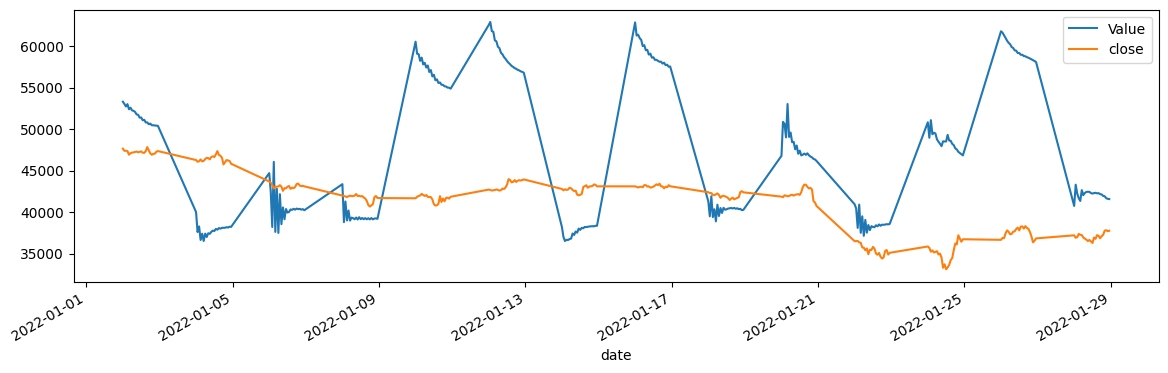

In [105]:
all_df = pd.concat(all_predicted_prices)
reserved_data['date'] = pd.to_datetime(reserved_data['date'])
all_df.rename(columns={'Date': 'date'}, inplace=True)
merged_df = pd.merge(all_df, reserved_data[['date', 'close']], on='date', how='left')
merged_df.head()
merged_df.set_index('date', inplace=True)
merged_df.plot()

In [60]:
print(returns)

[0.016154928394216235, 0.03570770908833176, 0.06520980389448323, 0.05177815881582234, 0.010359312387271108, 0.025811142350258665, 0.00562334175159874, 0.01691210888695196, 0.03278436706643353, 0.01700492836324265, 0.16346205232475872, 0.03277212268178554, 0.049685002889933896, 0.017967856639142358]


In [116]:
np.array(returns) + 1

array([1.01615493, 1.03570771, 1.0652098 , 1.05177816, 1.01035931,
       1.02581114, 1.00562334, 1.01691211, 1.03278437, 1.01700493,
       1.16346205, 1.03277212, 1.049685  , 1.01796786])

In [123]:
import math

rf = 0.04
fees_per_transaction = 0.005 # TODO

sum_returns = sum(returns)

# sharpe ratio calculation
sharpe = (sum_returns - rf) / (np.std(np.array(returns)) * math.sqrt(30))
print(sharpe)

2.386475974653475






---




















In [20]:
torch.save(model.state_dict(), "./model_hourly_close2.pt")